In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
input_file = 'structured_output_file.csv'  # Update with your actual dataset path
df = pd.read_csv(input_file)

# Inspect the dataset
print("Initial Data Shape:", df.shape)
print("Columns:", df.columns)
print(df.head())


Initial Data Shape: (211278, 15)
Columns: Index(['Port_IDs', 'time', 'symbol', 'side', 'price', 'fee', 'feeAsset',
       'quantity', 'quantityAsset', 'realizedProfit', 'realizedProfitAsset',
       'baseAsset', 'qty', 'positionSide', 'activeBuy'],
      dtype='object')
              Port_IDs          time    symbol side      price       fee  \
0  3925368433214965504  1.718900e+12   SOLUSDT  BUY  132.53700 -0.994027   
1  3925368433214965504  1.718900e+12  DOGEUSDT  BUY    0.12182 -0.279796   
2  3925368433214965504  1.718900e+12  DOGEUSDT  BUY    0.12182 -0.039494   
3  3925368433214965504  1.718900e+12  DOGEUSDT  BUY    0.12182 -0.008284   
4  3925368433214965504  1.718900e+12  DOGEUSDT  BUY    0.12182 -0.046109   

  feeAsset    quantity quantityAsset  realizedProfit realizedProfitAsset  \
0     USDT  1988.05500          USDT             0.0                USDT   
1     USDT  1398.98088          USDT             0.0                USDT   
2     USDT   197.47022          USDT        

/tmp/ipykernel_14056/2023975155.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


In [3]:
# Handle missing values
df.dropna(inplace=True)
print("Data Shape after dropping missing values:", df.shape)

# Check for duplicate entries
print("Duplicate Rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Data Shape after dropping duplicates:", df.shape)


Data Shape after dropping missing values: (211277, 15)
Duplicate Rows: 11251
Data Shape after dropping duplicates: (200026, 15)


In [4]:
# Create profit/loss indicator
df['profit_loss'] = np.where(df['realizedProfit'] > 0, 1, 0)

# Combine 'side' and 'positionSide' to classify trades
df['position_type'] = np.where((df['side'] == 'BUY') & (df['positionSide'] == 'LONG'), 'long_open', 
                                np.where((df['side'] == 'SELL') & (df['positionSide'] == 'LONG'), 'long_close', 'other'))

# Check the unique position types
print(df['position_type'].unique())


['long_open' 'long_close' 'other']


In [5]:
# Calculate financial metrics for each account
metrics = df.groupby('Port_IDs').agg(
    total_profit=pd.NamedAgg(column='realizedProfit', aggfunc='sum'),
    total_positions=pd.NamedAgg(column='profit_loss', aggfunc='count'),
    win_positions=pd.NamedAgg(column='profit_loss', aggfunc='sum'),
    win_rate=pd.NamedAgg(column='profit_loss', aggfunc='mean'),
    avg_trade=pd.NamedAgg(column='realizedProfit', aggfunc='mean'),
    fees=pd.NamedAgg(column='fee', aggfunc='sum')
).reset_index()

# Calculate ROI, Sharpe Ratio, and MDD
initial_investment = 10000  # Example initial investment
metrics['ROI'] = (metrics['total_profit'] / initial_investment) * 100
metrics['sharpe_ratio'] = metrics['avg_trade'] / metrics['fees']  # Simplified Sharpe Ratio
metrics['MDD'] = (metrics['total_profit'].min() / initial_investment) * 100  # Maximum Drawdown

# Show calculated metrics
print(metrics.head())


              Port_IDs  total_profit  total_positions  win_positions  \
0  3672754654734989568    565.547761              461            206   
1  3733192481840423936   2284.821155              585            456   
2  3768170840939476993    243.668899               13              6   
3  3784403294629753856   2493.618898             5833           1767   
4  3786761687746711808    170.220200               79             34   

   win_rate  avg_trade        fees        ROI  sharpe_ratio         MDD  
0  0.446855   1.226785  -35.382377   5.655478     -0.034672 -125.682379  
1  0.779487   3.905677 -436.059661  22.848212     -0.008957 -125.682379  
2  0.461538  18.743761   -0.888438   2.436689    -21.097428 -125.682379  
3  0.302932   0.427502 -354.838681  24.936189     -0.001205 -125.682379  
4  0.430380   2.154686  -28.373040   1.702202     -0.075941 -125.682379  


In [6]:
# Ranking accounts based on the calculated metrics
metrics['rank'] = metrics[['ROI', 'win_rate', 'sharpe_ratio']].mean(axis=1)
top_accounts = metrics.nlargest(20, 'rank')

# Show top 20 accounts
print(top_accounts[['Port_IDs', 'rank']])


                Port_IDs        rank
97   4020204877254599680  235.569943
76   3999240873283311617  140.735877
99   4021669203289716224   88.231054
51   3960874214179953664   64.425657
17   3907081197088384000   56.831259
49   3956076827719377409   55.564523
63   3986814617275053313   53.082484
108  4028701921959171840   52.664652
100  4022565861939831809   46.199050
23   3919965573764932864   46.137299
5    3788465932399412480   44.179292
64   3987739404272887297   41.529415
85   4008711265867865600   35.389417
31   3936410995029308417   34.647059
28   3931992636670880512   34.033448
74   3998572645139652353   31.537546
33   3939318616482048768   31.510162
52   3962024093501274881   31.475799
126  4031493134338259457   29.749743
38   3944088772635000577   25.057889


In [7]:
# Save calculated metrics to CSV files
metrics.to_csv('calculated_metrics.csv', index=False)
top_accounts.to_csv('top_20_accounts.csv', index=False)

print("Metrics saved to 'calculated_metrics.csv' and 'top_20_accounts.csv'.")


Metrics saved to 'calculated_metrics.csv' and 'top_20_accounts.csv'.


# **Conclusion**

In this analysis, we have examined the historical trade data from various Binance accounts, calculating key financial metrics such as ROI, PnL, Sharpe Ratio, and MDD. We ranked the accounts based on their performance and identified the top 20 accounts. 

## Findings
1. Accounts with higher ROI also tend to have a higher win rate.
2. The average trade profitability correlates with the total profit realized.

### Assumptions
- The initial investment is assumed to be $10,000 for ROI calculations.
- Fees are considered in the calculation of the Sharpe Ratio.


# **Plots**


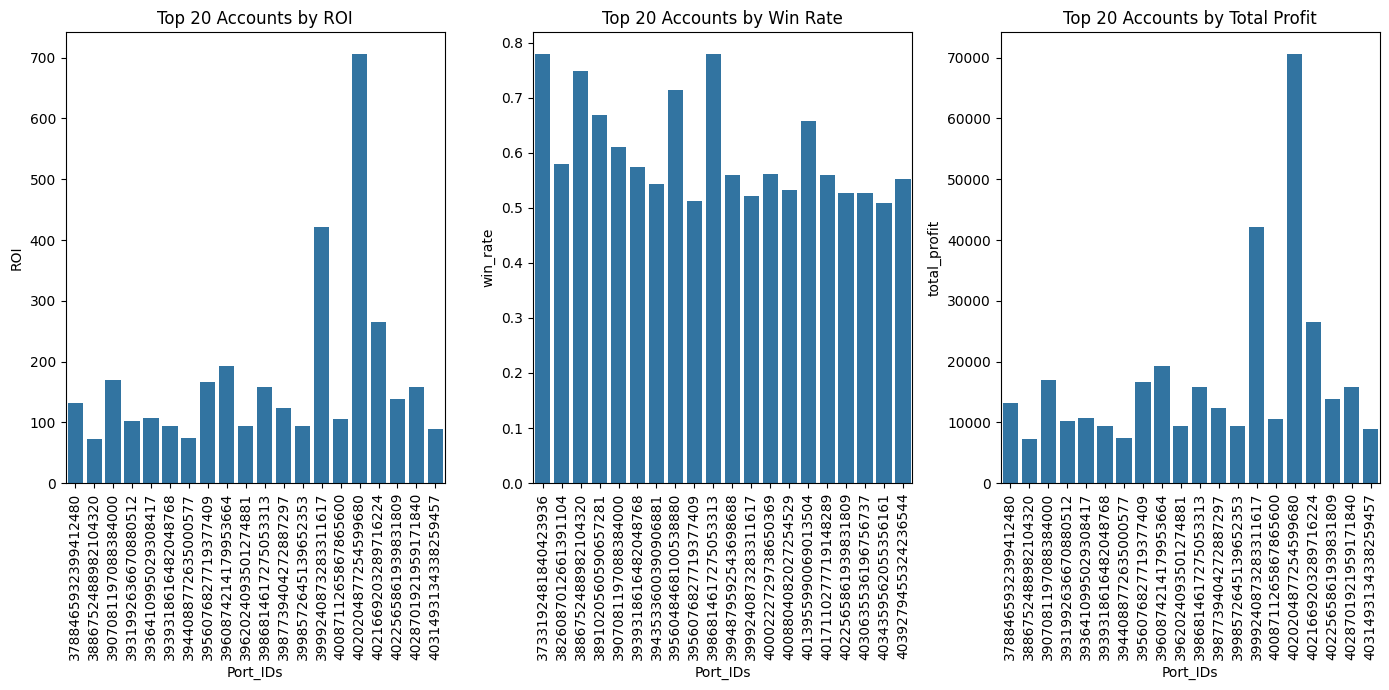

In [8]:
# Visualization of key metrics
plt.figure(figsize=(14, 7))

# Plot ROI
plt.subplot(1, 3, 1)
sns.barplot(x='Port_IDs', y='ROI', data=metrics.sort_values('ROI', ascending=False).head(20))
plt.title('Top 20 Accounts by ROI')
plt.xticks(rotation=90)

# Plot Win Rate
plt.subplot(1, 3, 2)
sns.barplot(x='Port_IDs', y='win_rate', data=metrics.sort_values('win_rate', ascending=False).head(20))
plt.title('Top 20 Accounts by Win Rate')
plt.xticks(rotation=90)

# Plot Total Profit
plt.subplot(1, 3, 3)
sns.barplot(x='Port_IDs', y='total_profit', data=metrics.sort_values('total_profit', ascending=False).head(20))
plt.title('Top 20 Accounts by Total Profit')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


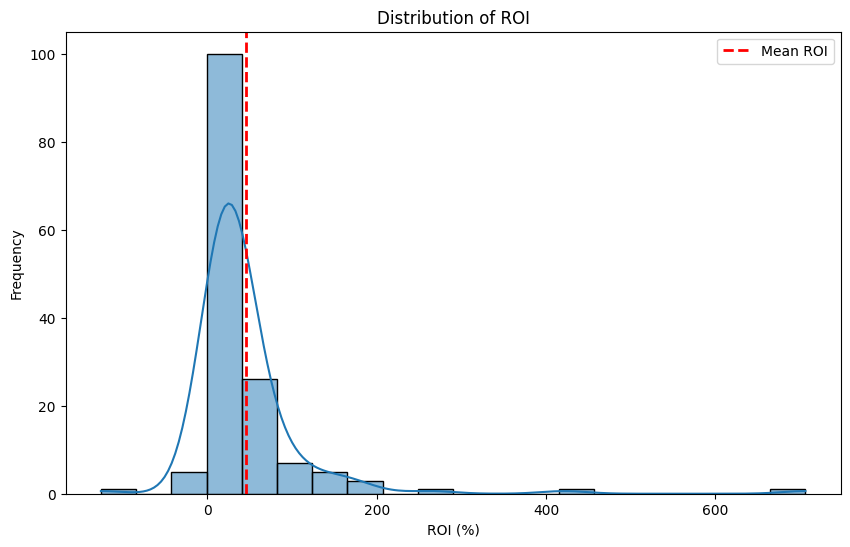

In [10]:
# Histogram of ROI
plt.figure(figsize=(10, 6))
sns.histplot(metrics['ROI'], bins=20, kde=True)
plt.title('Distribution of ROI')
plt.xlabel('ROI (%)')
plt.ylabel('Frequency')
plt.axvline(metrics['ROI'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean ROI')
plt.legend()
plt.show()


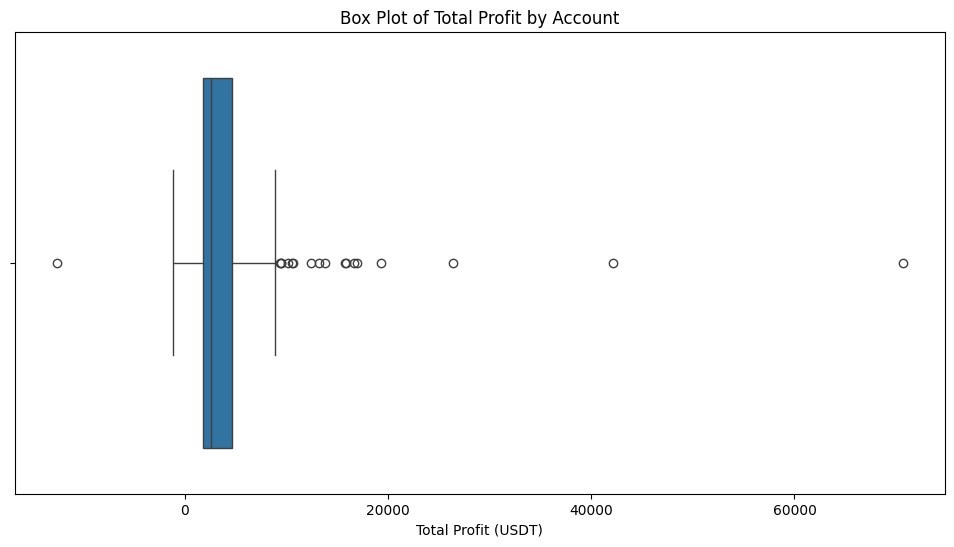

In [11]:
# Box plot of total profit by account
plt.figure(figsize=(12, 6))
sns.boxplot(x='total_profit', data=metrics)
plt.title('Box Plot of Total Profit by Account')
plt.xlabel('Total Profit (USDT)')
plt.show()


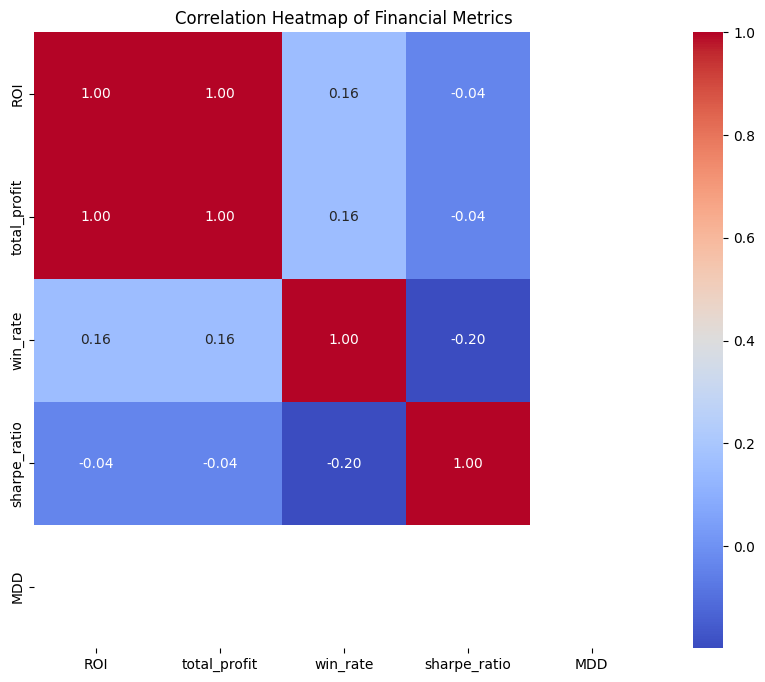

In [13]:
# Correlation heatmap of financial metrics
plt.figure(figsize=(10, 8))
correlation_matrix = metrics[['ROI', 'total_profit', 'win_rate', 'sharpe_ratio', 'MDD']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()


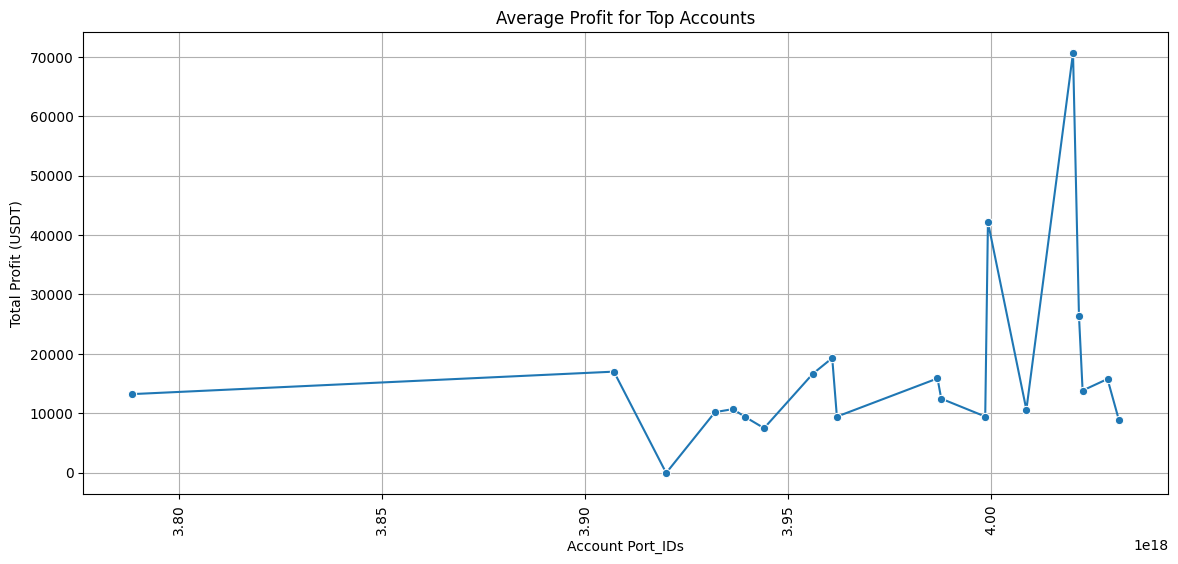

In [14]:
# Line plot of average profit for top accounts
plt.figure(figsize=(14, 6))
sns.lineplot(data=top_accounts.sort_values('rank'), x='Port_IDs', y='total_profit', marker='o')
plt.title('Average Profit for Top Accounts')
plt.xlabel('Account Port_IDs')
plt.ylabel('Total Profit (USDT)')
plt.xticks(rotation=90)
plt.grid()
plt.show()


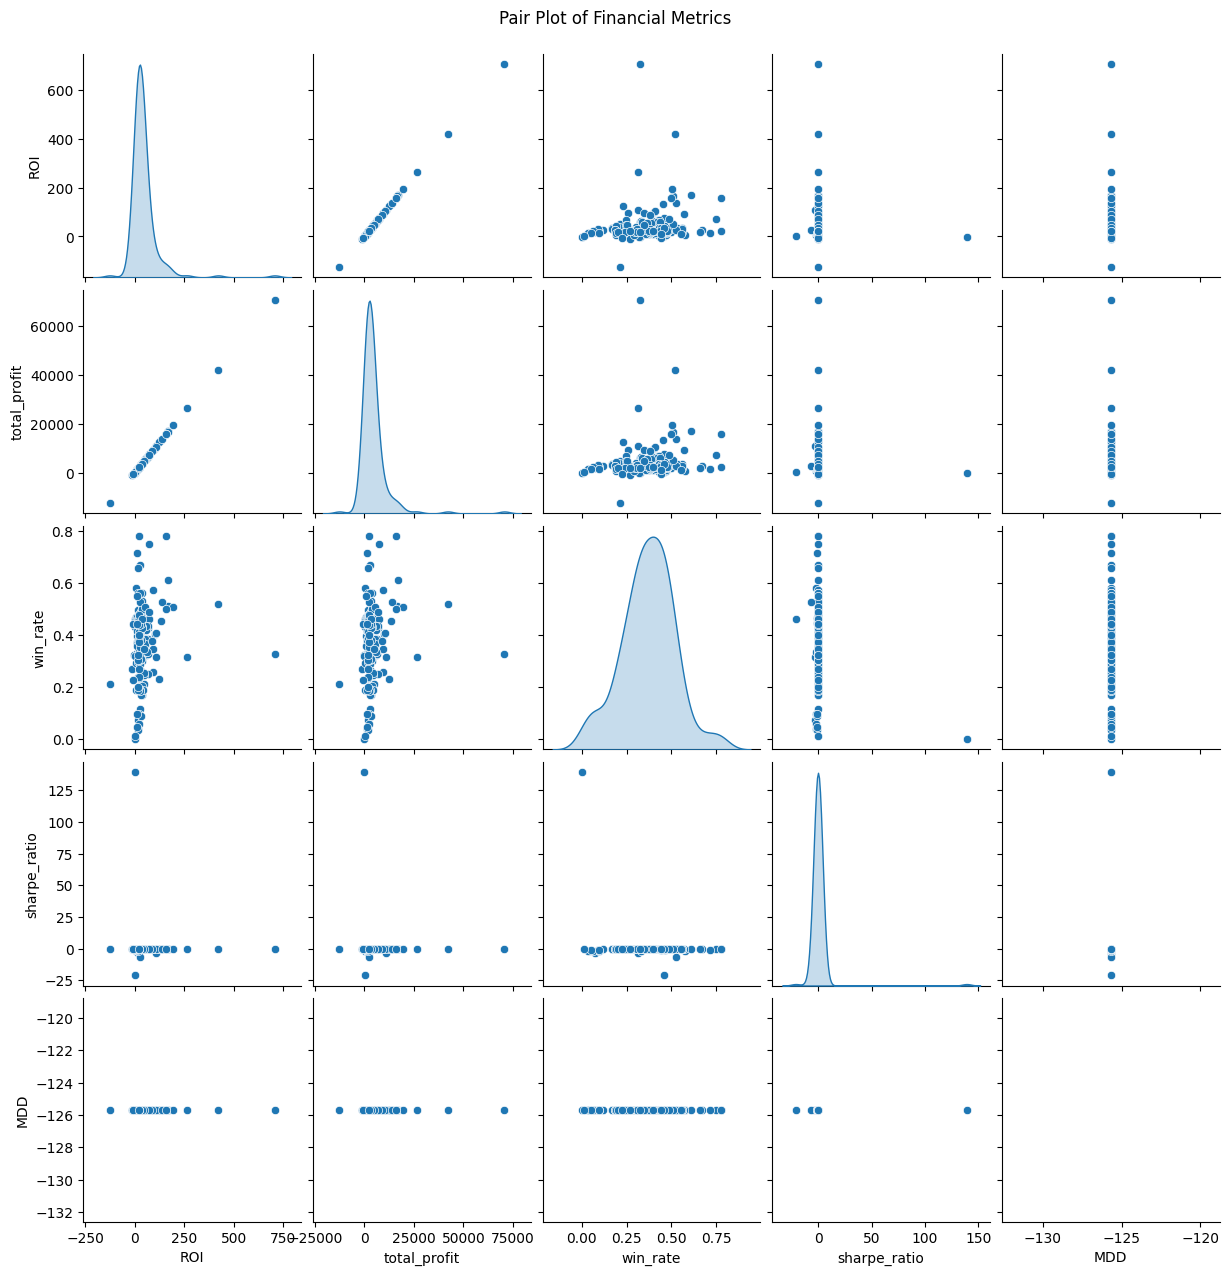

In [15]:
# Pair plot of selected financial metrics
sns.pairplot(metrics[['ROI', 'total_profit', 'win_rate', 'sharpe_ratio', 'MDD']], diag_kind='kde')
plt.suptitle('Pair Plot of Financial Metrics', y=1.02)
plt.show()


/tmp/ipykernel_14056/4281790211.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


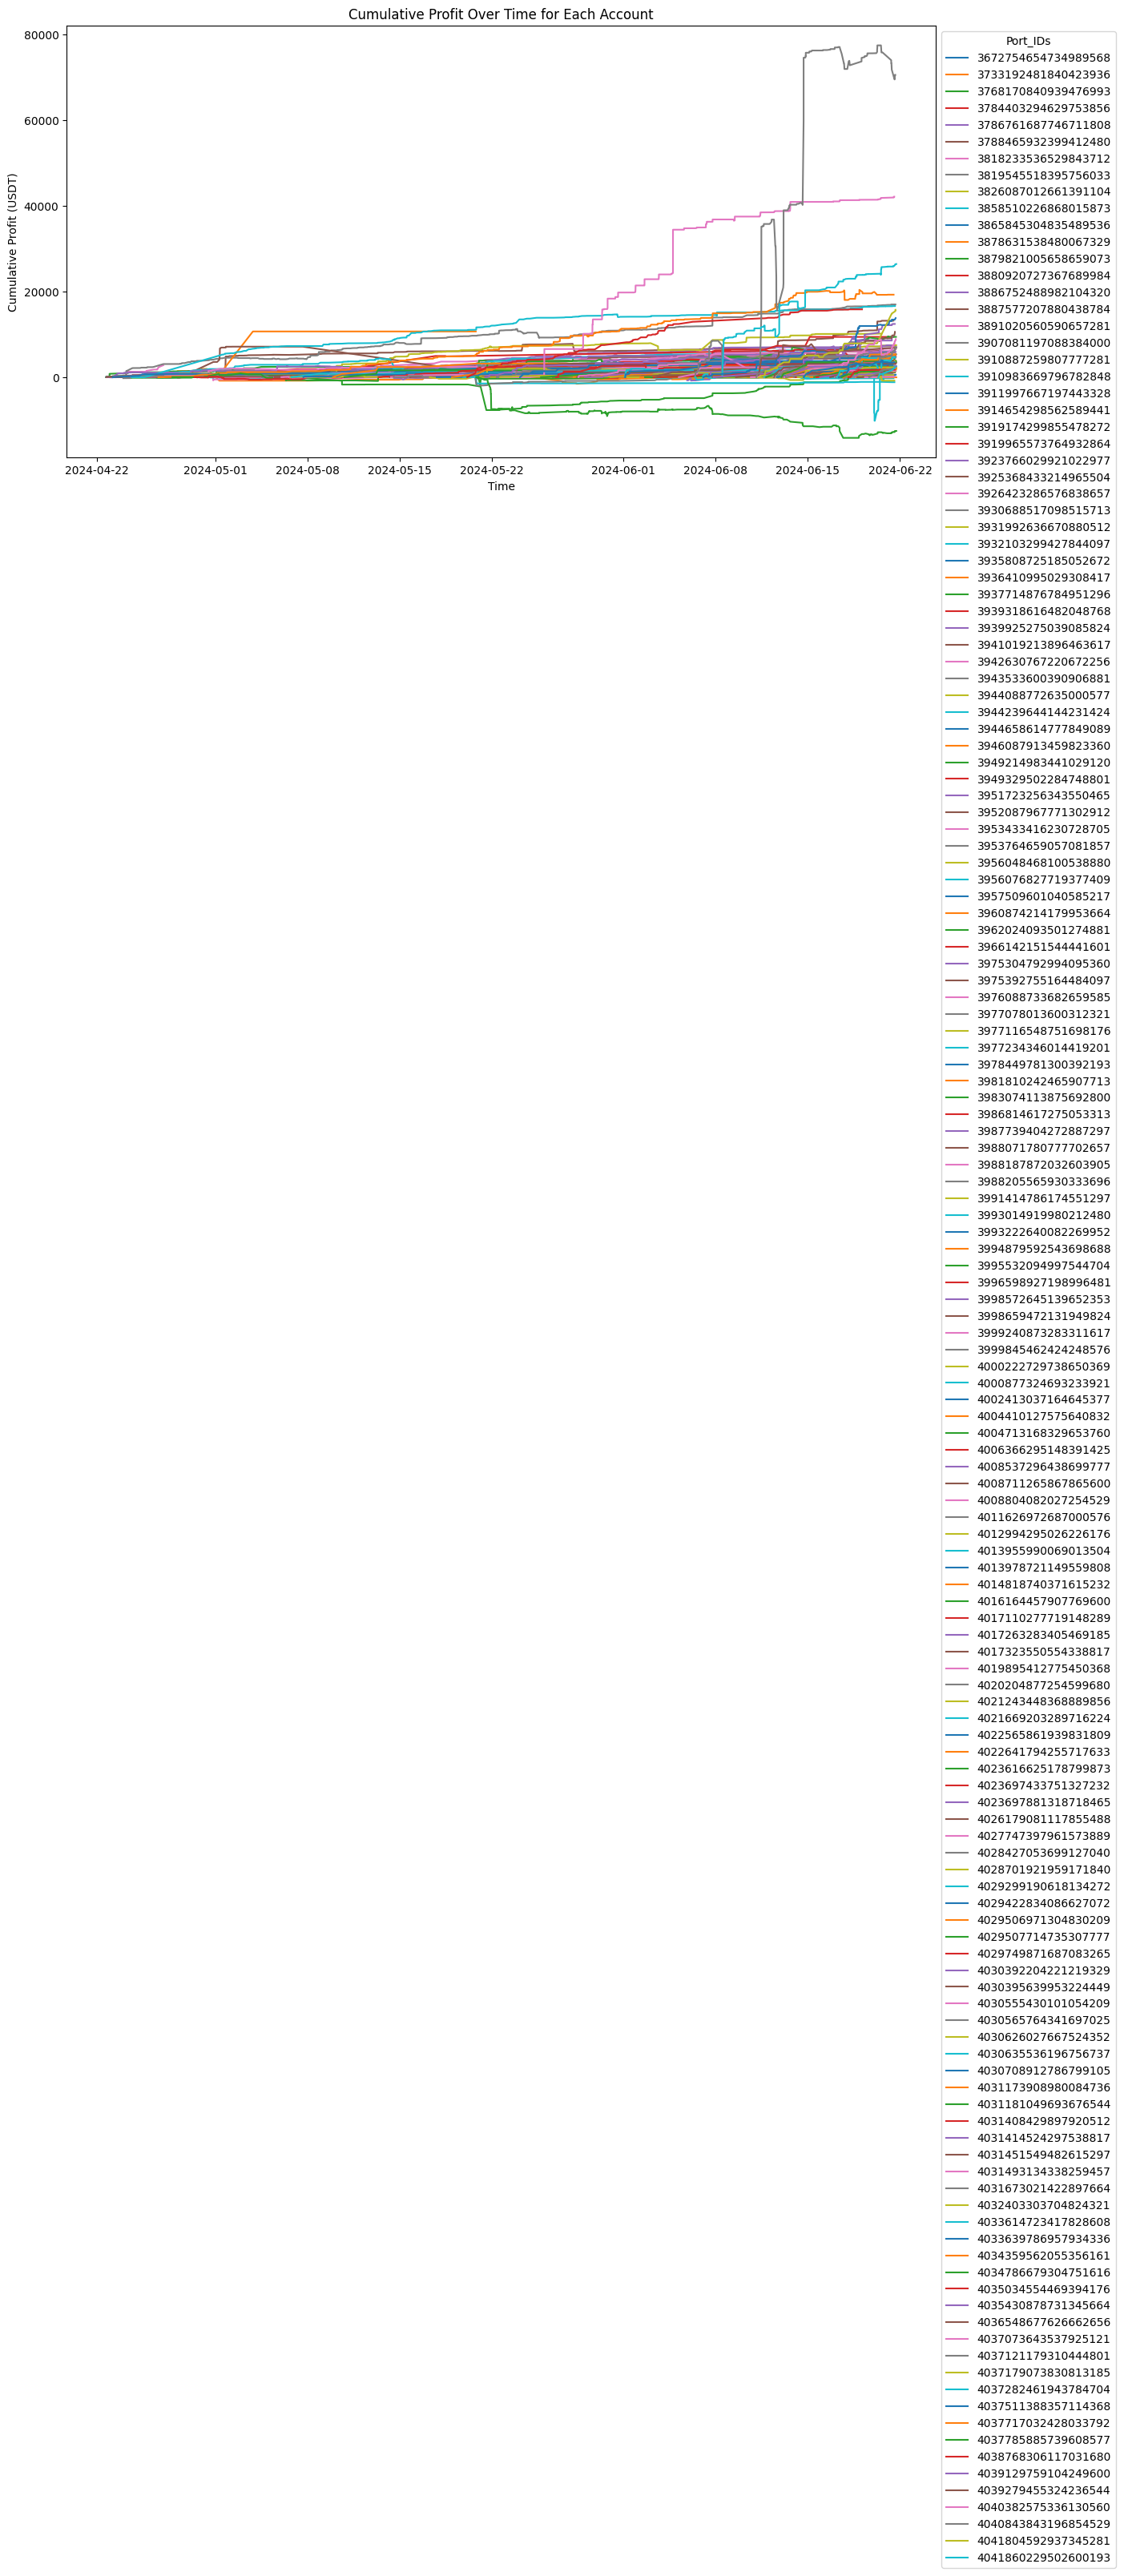

In [16]:
# Cumulative profit over time for each account
df['time'] = pd.to_datetime(df['time'], unit='ms')  # Convert time from milliseconds to datetime
cumulative_profit = df.groupby(['Port_IDs', 'time'])['realizedProfit'].sum().groupby(level=0).cumsum().reset_index()

plt.figure(figsize=(14, 7))
for key, grp in cumulative_profit.groupby(['Port_IDs']):
    plt.plot(grp['time'], grp['realizedProfit'], label=key)

plt.title('Cumulative Profit Over Time for Each Account')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit (USDT)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Port_IDs')
plt.tight_layout()
plt.show()
